In [1]:
# Check Python libraries available on cluster
sc.list_packages()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1704813021947_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package              Version
-------------------- ------------
appdirs              1.4.4
attrs                20.3.0
aws-cfn-bootstrap    2.0
awscli               2.14.5
awscrt               0.19.19
Babel                2.9.1
beautifulsoup4       4.9.3
boto                 2.49.0
cffi                 1.14.5
chardet              4.0.0
chevron              0.13.1
click                8.1.7
cloud-init           22.2.2
colorama             0.4.4
configobj            5.0.6
cryptography         36.0.1
dbus-python          1.2.18
distlib              0.3.1
distro               1.5.0
docutils             0.16
ec2-hibinit-agent    1.0.2
filelock             3.0.12
gpg                  1.15.1
idna                 2.10
Jinja2               2.11.3
jmespath             1.0.1
joblib               1.3.2
jsonpatch            1.21
jsonpointer          2.0
jsonschema           3.2.0
libcomps             0.1.18
lockfile             0.12.2
lxml                 4.9.3
MarkupSafe           1.1.1
mysqlclient

In [2]:
# Install necessary libraries
sc.install_pypi_package("pandas")
sc.install_pypi_package("matplotlib")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Not uninstalling python-dateutil at /usr/lib/python3.9/site-packages, outside environment /mnt1/yarn/usercache/livy/appcache/application_1704813021947_0001/container_1704813021947_0001_01_000001/tmp/spark-72e15243-7f67-4f4d-a178-93fecaac685b
    Can't uninstall 'python-dateutil'. No files were found to uninstall.




In [195]:
# Load libraries
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# Initialize SparkSession
spark = SparkSession.builder.appName("EMR Notebook").getOrCreate()

# Read data from S3
matches = spark.read.parquet("s3://processed-tennis-stats-data/matches")
players = spark.read.parquet("s3://processed-tennis-stats-data/players")
rankings = spark.read.parquet("s3://processed-tennis-stats-data/rankings")

matches.printSchema()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- tourney_id: string (nullable = true)
 |-- tourney_name: string (nullable = true)
 |-- surface: string (nullable = true)
 |-- draw_size: long (nullable = true)
 |-- tourney_level: string (nullable = true)
 |-- tourney_date: date (nullable = true)
 |-- match_num: long (nullable = true)
 |-- winner_id: string (nullable = true)
 |-- winner_seed: string (nullable = true)
 |-- winner_entry: string (nullable = true)
 |-- winner_name: string (nullable = true)
 |-- winner_hand: string (nullable = true)
 |-- winner_ht: string (nullable = true)
 |-- winner_ioc: string (nullable = true)
 |-- winner_age: string (nullable = true)
 |-- loser_id: string (nullable = true)
 |-- loser_entry: string (nullable = true)
 |-- loser_name: string (nullable = true)
 |-- loser_hand: string (nullable = true)
 |-- loser_ht: double (nullable = true)
 |-- loser_ioc: string (nullable = true)
 |-- loser_age: double (nullable = true)
 |-- score: string (nullable = true)
 |-- best_of: long (nullable = true)
 |-

### Court surface win ratio

In [5]:
from pyspark.sql.functions import col, when

player = 'Daniil Medvedev'

# Filter records where 'winner_name' or 'loser_name' is equal to player
filtered_matches = matches.filter((col('winner_name') == player) | (col('loser_name') == player))

# Calculate win ratio based on surface
counts = (
    filtered_matches
    .select(
        'surface',
        when(col('winner_name') == 'Daniil Medvedev', 1).otherwise(0).alias('won_count'),
        when(col('loser_name') == 'Daniil Medvedev', 1).otherwise(0).alias('lost_count')
    )
    .groupBy('surface')
    .agg({'won_count': 'sum', 'lost_count': 'sum'})
    .withColumn('win_ratio', col('sum(won_count)') / col('sum(lost_count)'))
    .orderBy('surface')
)

# Show the resulting counts and ratios
counts.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------------+--------------+------------------+
|surface|sum(lost_count)|sum(won_count)|         win_ratio|
+-------+---------------+--------------+------------------+
| Carpet|              5|            12|               2.4|
|   Clay|             43|            71|1.6511627906976745|
|  Grass|             22|            50| 2.272727272727273|
|   Hard|            124|           348| 2.806451612903226|
+-------+---------------+--------------+------------------+

### Quality of serve depending on ranking

In [6]:
# Calculate winner 1st serve % for each record
matches2 = matches.withColumn('w_1st%', matches['w_1stIn'] / matches['w_svpt'] * 100) \
                  .withColumn('l_1st%', matches['l_1stIn'] / matches['l_svpt'] * 100)

# Calculate average winner 1st serve % for each ranking
w_1stp = (
    matches2.filter(matches2['tour'] == 'ATP')
    .groupBy('winner_rank')
    .agg({'w_1st%': 'avg'})
    .withColumnRenamed('avg(w_1st%)', 'w_avg_1st_percentage')
    .orderBy('winner_rank')
    .toPandas()
)

# Calculate average loser 1st serve % for each ranking
l_1stp = (
    matches2.filter(matches2['tour'] == 'ATP')
    .groupBy('loser_rank')
    .agg({'l_1st%': 'avg'})
    .withColumnRenamed('avg(l_1st%)', 'l_avg_1st_percentage')
    .orderBy('loser_rank')
    .toPandas()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# Pre-process the DataFrames
# Drop NaNs
w_1stp.dropna(inplace=True)
l_1stp.dropna(inplace=True)
# Filter rankings outside of specified numbers
lower_rank = 1
upper_rank = 800
filtered_w_1stp = w_1stp[(w_1stp['winner_rank'] >= lower_rank) & (w_1stp['winner_rank'] <= upper_rank)]
filtered_l_1stp = l_1stp[(l_1stp['loser_rank'] >= lower_rank) & (l_1stp['loser_rank'] <= upper_rank)]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# Extract data for plotting
winner_ranks = filtered_w_1stp['winner_rank']
w_avg_1st_percentages = filtered_w_1stp['w_avg_1st_percentage']

loser_ranks = filtered_l_1stp['loser_rank']
l_avg_1st_percentages = filtered_l_1stp['l_avg_1st_percentage']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

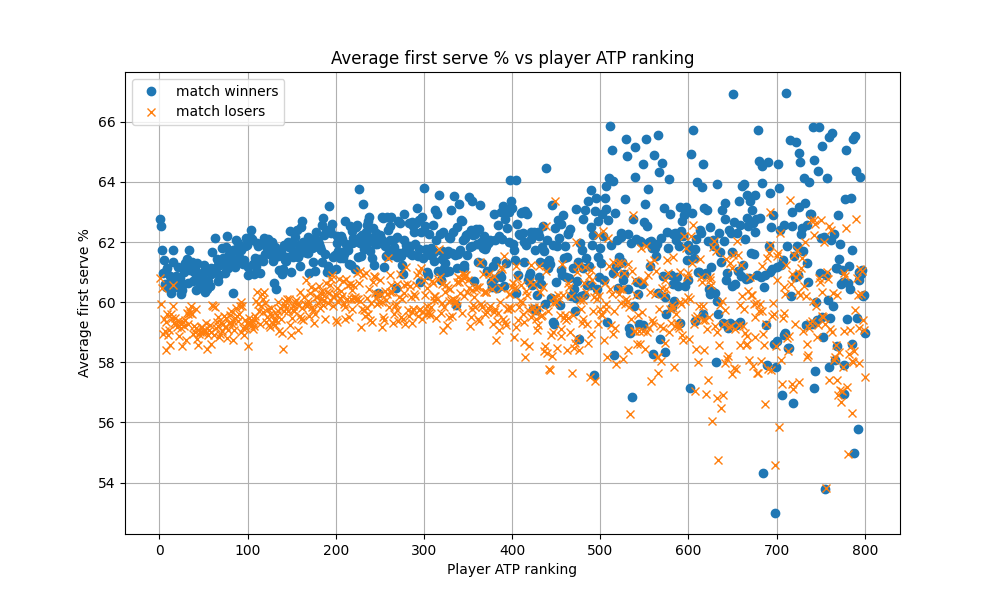

In [9]:
# Plotting using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(winner_ranks, w_avg_1st_percentages, marker='o', linestyle='', label='match winners')
ax.plot(loser_ranks, l_avg_1st_percentages, marker='x', linestyle='', label='match losers')
ax.set_xlabel('Player ATP ranking')
ax.set_ylabel('Average first serve in percentage [%]')
ax.set_title('Average first serve in % vs player ATP ranking')
ax.grid(True)
ax.legend()
ax.set_xlim([lower_rank-40, upper_rank+40])
plt.show()
%matplot plt

#### Show player example quality serve trajectory

In [10]:
# Get trajectory of 1st serve percentage of player as he was climbing the ranking
player = 'Daniil Medvedev'

# Calculate average winner 1st serve % for each ranking
w_1stp_player = (
    matches2.filter(matches2['winner_name'] == player)
    .groupBy('winner_rank')
    .agg({'w_1st%': 'avg'})
    .withColumnRenamed('avg(w_1st%)', 'w_avg_1st_percentage')
    .orderBy('winner_rank')
    .toPandas()
)

# Calculate average loser 1st serve % for each ranking
l_1stp_player = (
    matches2.filter(matches2['loser_name'] == player)
    .groupBy('loser_rank')
    .agg({'l_1st%': 'avg'})
    .withColumnRenamed('avg(l_1st%)', 'l_avg_1st_percentage')
    .orderBy('loser_rank')
    .toPandas()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
# Calculate rolling average for better plottign for a single player
window_size = 10
w_1stp_player['running_average'] = w_1stp_player['w_avg_1st_percentage'].rolling(window=window_size, min_periods=5).mean()
l_1stp_player['running_average'] = l_1stp_player['l_avg_1st_percentage'].rolling(window=window_size, min_periods=5).mean()

# Extract data for plotting
wr_pl = w_1stp_player['winner_rank']
w1st_pl = w_1stp_player['running_average']

lr_pl = l_1stp_player['loser_rank']
l1st_pl = l_1stp_player['running_average']


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

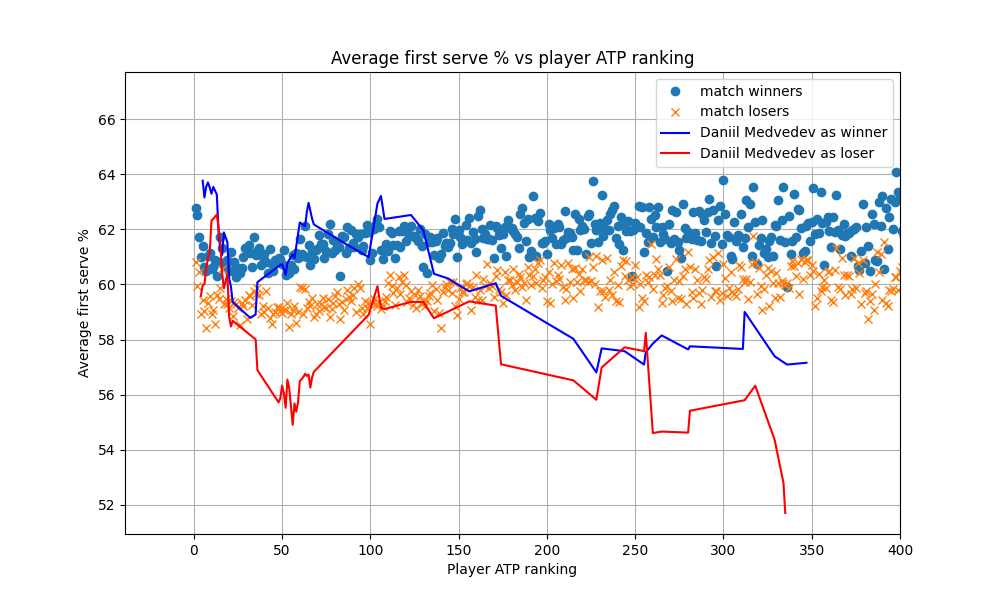

In [12]:
# Plotting using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(winner_ranks, w_avg_1st_percentages, marker='o', linestyle='', label='match winners')
ax.plot(loser_ranks, l_avg_1st_percentages, marker='x', linestyle='', label='match losers')
ax.plot(wr_pl, w1st_pl, 'b-', label=f'{player} as winner')
ax.plot(lr_pl, l1st_pl, 'r-', label=f'{player} as loser')
ax.set_xlabel('Player ATP ranking')
ax.set_ylabel('Average first serve in percentage [%]')
ax.set_title('Average first serve in % vs player ATP ranking')
ax.grid(True)
ax.legend()
ax.set_xlim([lower_rank-40, 400])
plt.show()
%matplot plt

In [13]:
# Get trajectory of 1st serve percentage of player as he was climbing the ranking
player = 'Diego Schwartzman'

# Calculate average winner 1st serve % for each ranking
w_1stp_player = (
    matches2.filter(matches2['winner_name'] == player)
    .groupBy('winner_rank')
    .agg({'w_1st%': 'avg'})
    .withColumnRenamed('avg(w_1st%)', 'w_avg_1st_percentage')
    .orderBy('winner_rank')
    .toPandas()
)

# Calculate average loser 1st serve % for each ranking
l_1stp_player = (
    matches2.filter(matches2['loser_name'] == player)
    .groupBy('loser_rank')
    .agg({'l_1st%': 'avg'})
    .withColumnRenamed('avg(l_1st%)', 'l_avg_1st_percentage')
    .orderBy('loser_rank')
    .toPandas()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
# Calculate rolling average for better plottign for a single player
window_size = 10
w_1stp_player['running_average'] = w_1stp_player['w_avg_1st_percentage'].rolling(window=window_size, min_periods=5).mean()
l_1stp_player['running_average'] = l_1stp_player['l_avg_1st_percentage'].rolling(window=window_size, min_periods=5).mean()

# Extract data for plotting
wr_pl = w_1stp_player['winner_rank']
w1st_pl = w_1stp_player['running_average']

lr_pl = l_1stp_player['loser_rank']
l1st_pl = l_1stp_player['running_average']


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

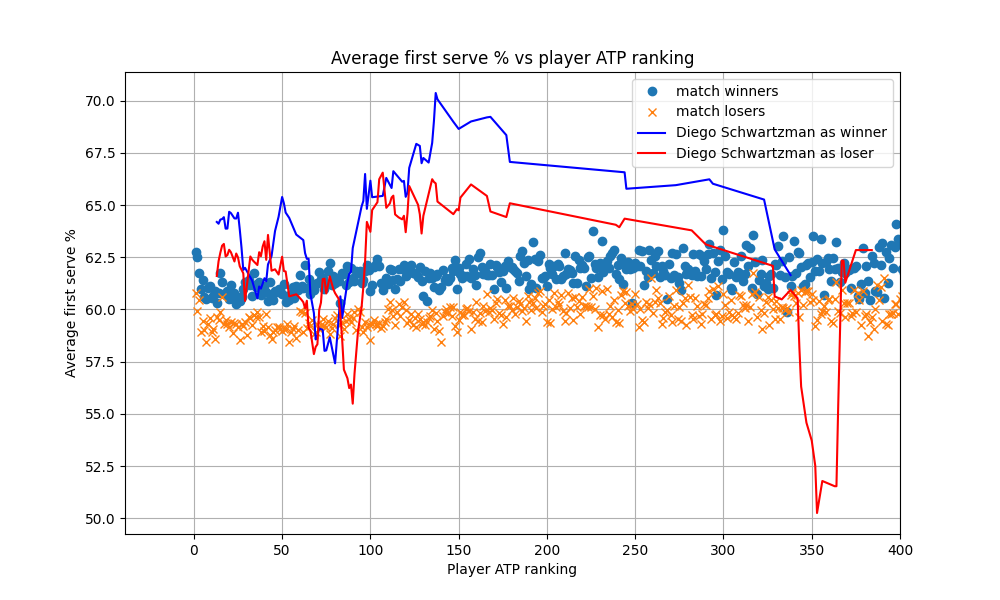

In [15]:
# Plotting using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(winner_ranks, w_avg_1st_percentages, marker='o', linestyle='', label='match winners')
ax.plot(loser_ranks, l_avg_1st_percentages, marker='x', linestyle='', label='match losers')
ax.plot(wr_pl, w1st_pl, 'b-', label=f'{player} as winner')
ax.plot(lr_pl, l1st_pl, 'r-', label=f'{player} as loser')
ax.set_xlabel('Player ATP ranking')
ax.set_ylabel('Average first serve in percentage [%]')
ax.set_title('Average first serve in % vs player ATP ranking')
ax.grid(True)
ax.legend()
ax.set_xlim([lower_rank-40, 400])
plt.show()
%matplot plt

### Player tiredness affecting win %

In [41]:
# Create 'r32' DataFrame
r32 = matches.filter((col('tour') == 'ATP') & (col('best_of') == '3') & (col('round') == 'R32')) \
             .withColumn('games_played_r32', col('winner_games') + col('loser_games')) \
             .select('tourney_id', 'winner_id','games_played_r32')
r32.show()

# Create 'r16' DataFrame
r16 = matches.filter((col('tour') == 'ATP') & (col('best_of') == '3') & (col('round') == 'R16')) \
             .select('tourney_id', 'winner_id','loser_id')
r16.show()

# Join 'r16' with 'r32' to add 'winner_games_played_r32' column
r16_with_winners = r16.join(r32, (r16['tourney_id'] == r32['tourney_id']) & (r16['winner_id'] == r32['winner_id']),
                                 'inner') \
                    .withColumnRenamed('games_played_r32', 'winner_games_played_r32') \
                    .drop(r32['tourney_id']).drop(r32['winner_id'])
r16_with_winners.show()

# Join 'r16' with 'r32' to add 'loser_games_played_r32' column
r16_with_losers = r16.join(r32, (r16['tourney_id'] == r32['tourney_id']) & (r16['loser_id'] == r32['winner_id']),
                                 'inner') \
                    .withColumnRenamed('games_played_r32', 'loser_games_played_r32') \
                    .drop(r32['tourney_id']).drop(r32['winner_id'])
r16_with_losers.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---------+----------------+
|tourney_id|winner_id|games_played_r32|
+----------+---------+----------------+
| 2022-7841|   104897|              15|
| 2022-7841|   106162|              18|
| 2022-7841|   122078|              17|
| 2022-7841|   207925|              26|
| 2022-7841|   111460|            NULL|
| 2022-7841|   106288|              18|
| 2022-7841|   111505|            NULL|
| 2022-7841|   105341|              20|
| 2022-7841|   106099|              23|
| 2022-7841|   105671|              28|
| 2022-7841|   200267|            NULL|
| 2022-7841|   126409|            NULL|
| 2022-7841|   124014|              14|
| 2022-7841|   105359|            NULL|
| 2022-7841|   106057|            NULL|
| 2022-7841|   200240|            NULL|
| 2022-9678|   123961|              17|
| 2022-9678|   106164|            NULL|
| 2022-9678|   208882|            NULL|
| 2022-9678|   202197|              26|
+----------+---------+----------------+
only showing top 20 rows

+----------+--

In [43]:
# Count occurrences of each value in 'winner_games_played_r32' and 'loser_games_played_r32'
winner_count = r16_with_winners.groupBy('winner_games_played_r32').count()
loser_count = r16_with_losers.groupBy('loser_games_played_r32').count()

# Show the counts
winner_count.show()
loser_count.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------------+-----+
|winner_games_played_r32|count|
+-----------------------+-----+
|                   NULL|36819|
|                     12| 1595|
|                     13| 4369|
|                     14| 8317|
|                     15|12369|
|                     16|16541|
|                     17|17823|
|                     18|16728|
|                     19|14191|
|                     20|10844|
|                     21| 5466|
|                     22| 5983|
|                     23| 2641|
|                     24| 3158|
|                     25| 3979|
|                     26| 4712|
|                     27| 4768|
|                     28| 4471|
|                     29| 3937|
|                     30| 2939|
+-----------------------+-----+
only showing top 20 rows

+----------------------+-----+
|loser_games_played_r32|count|
+----------------------+-----+
|                  NULL|42351|
|                    12| 1168|
|                    13| 3278|
|                   

In [50]:
# Rename columns in 'winner_count'
winner_count = winner_count.withColumnRenamed('winner_games_played_r32', 'games_played_r32') \
                           .withColumnRenamed('count', 'r16_wins_count')

# Rename columns in 'loser_count'
loser_count = loser_count.withColumnRenamed('loser_games_played_r32', 'games_played_r32') \
                         .withColumnRenamed('count', 'r16_losses_count')

# Join 'winner_count' and 'loser_count' DataFrames
# Filter values with total games played above 39 (max in 3 sets) and below 12 (min in 3 sets)
combined_counts = winner_count.join(loser_count, 'games_played_r32', 'outer') \
                              .dropna().filter((col('games_played_r32') >= 12) & (col('games_played_r32') <= 39))

# Add 'win_fraction' column
combined_counts = combined_counts.withColumn('win_fraction', col('r16_wins_count') / (col('r16_wins_count') + col('r16_losses_count')))

# Show the resulting DataFrame with the desired columns
combined_counts.show(n=40)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+--------------+----------------+-------------------+
|games_played_r32|r16_wins_count|r16_losses_count|       win_fraction|
+----------------+--------------+----------------+-------------------+
|              12|          1595|            1168| 0.5772710821570757|
|              13|          4369|            3278| 0.5713351641166471|
|              14|          8317|            6460|   0.56283413412736|
|              15|         12369|           10127|  0.549831081081081|
|              16|         16541|           13847| 0.5443267079110176|
|              17|         17823|           16121| 0.5250707046900778|
|              18|         16728|           15872| 0.5131288343558282|
|              19|         14191|           14140| 0.5009000741237514|
|              20|         10844|           10910|   0.49848303760228|
|              21|          5466|            5765| 0.4866886296856914|
|              22|          5983|            6466|  0.480600851474014|
|     

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

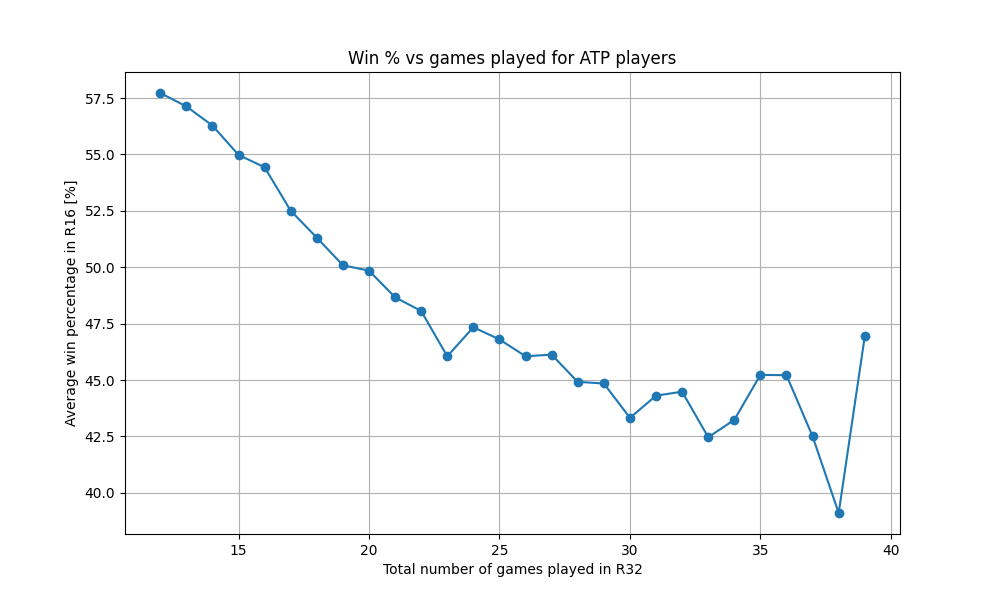

In [54]:
df = combined_counts.orderBy('games_played_r32').toPandas()
games = df['games_played_r32']
win_p = df['win_fraction'] * 100

# Plotting using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(games, win_p, marker='o')
ax.set_xlabel('Total number of games played in R32')
ax.set_ylabel('Average win percentage in R16 [%]')
ax.set_title('Win % vs games played for ATP players')
ax.grid(True)
plt.show()
%matplot plt

#### Check performance of specific player

In [117]:
nation = 'ESP'

# Create 'r32' DataFrame
r32 = matches.filter((col('tour') == 'ATP') & (col('best_of') == '3') & (col('round') == 'R32')) \
             .withColumn('games_played_r32', col('winner_games') + col('loser_games')) \
             .select('tourney_id', 'winner_id','games_played_r32') \
             .filter((col('winner_ioc') == nation) | (col('loser_ioc') == nation))

# Create 'r16' DataFrame
r16 = matches.filter((col('tour') == 'ATP') & (col('best_of') == '3') & (col('round') == 'R16')) \
             .select('tourney_id', 'winner_id','loser_id') \
             .filter((col('winner_ioc') == nation) | (col('loser_ioc') == nation))

# Join 'r16' with 'r32' to add 'winner_games_played_r32' column
r16_with_winners = r16.join(r32, (r16['tourney_id'] == r32['tourney_id']) & (r16['winner_id'] == r32['winner_id']),
                                 'inner') \
                    .withColumnRenamed('games_played_r32', 'winner_games_played_r32') \
                    .drop(r32['tourney_id']).drop(r32['winner_id'])

# Join 'r16' with 'r32' to add 'loser_games_played_r32' column
r16_with_losers = r16.join(r32, (r16['tourney_id'] == r32['tourney_id']) & (r16['loser_id'] == r32['winner_id']),
                                 'inner') \
                    .withColumnRenamed('games_played_r32', 'loser_games_played_r32') \
                    .drop(r32['tourney_id']).drop(r32['winner_id'])

# Count occurrences of each value in 'winner_games_played_r32' and 'loser_games_played_r32'
winner_count = r16_with_winners.groupBy('winner_games_played_r32').count()
loser_count = r16_with_losers.groupBy('loser_games_played_r32').count()

# Rename columns in 'winner_count'
winner_count = winner_count.withColumnRenamed('winner_games_played_r32', 'games_played_r32') \
                           .withColumnRenamed('count', 'r16_wins_count')

# Rename columns in 'loser_count'
loser_count = loser_count.withColumnRenamed('loser_games_played_r32', 'games_played_r32') \
                         .withColumnRenamed('count', 'r16_losses_count')

# Join 'winner_count' and 'loser_count' DataFrames
# Filter values with total games played above 39 (max in 3 sets) and below 12 (min in 3 sets)
combined_counts = winner_count.join(loser_count, 'games_played_r32', 'outer') \
                              .dropna().filter((col('games_played_r32') >= 12) & (col('games_played_r32') <= 39))

# Add 'win_fraction' column
combined_counts = combined_counts.withColumn('win_fraction', col('r16_wins_count') / (col('r16_wins_count') + col('r16_losses_count')))

# Extract data for plotting. Remove rows is few matches available
df = combined_counts.orderBy('games_played_r32').toPandas()
cutoff = 20
df = df[(df['r16_wins_count'] + df['r16_losses_count']) >= 20]
games_1 = df['games_played_r32']
win_p_1 = df['win_fraction'] * 100

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [118]:
nation = 'GBR'

# Create 'r32' DataFrame
r32 = matches.filter((col('tour') == 'ATP') & (col('best_of') == '3') & (col('round') == 'R32')) \
             .withColumn('games_played_r32', col('winner_games') + col('loser_games')) \
             .select('tourney_id', 'winner_id','games_played_r32') \
             .filter((col('winner_ioc') == nation) | (col('loser_ioc') == nation))

# Create 'r16' DataFrame
r16 = matches.filter((col('tour') == 'ATP') & (col('best_of') == '3') & (col('round') == 'R16')) \
             .select('tourney_id', 'winner_id','loser_id') \
             .filter((col('winner_ioc') == nation) | (col('loser_ioc') == nation))

# Join 'r16' with 'r32' to add 'winner_games_played_r32' column
r16_with_winners = r16.join(r32, (r16['tourney_id'] == r32['tourney_id']) & (r16['winner_id'] == r32['winner_id']),
                                 'inner') \
                    .withColumnRenamed('games_played_r32', 'winner_games_played_r32') \
                    .drop(r32['tourney_id']).drop(r32['winner_id'])

# Join 'r16' with 'r32' to add 'loser_games_played_r32' column
r16_with_losers = r16.join(r32, (r16['tourney_id'] == r32['tourney_id']) & (r16['loser_id'] == r32['winner_id']),
                                 'inner') \
                    .withColumnRenamed('games_played_r32', 'loser_games_played_r32') \
                    .drop(r32['tourney_id']).drop(r32['winner_id'])

# Count occurrences of each value in 'winner_games_played_r32' and 'loser_games_played_r32'
winner_count = r16_with_winners.groupBy('winner_games_played_r32').count()
loser_count = r16_with_losers.groupBy('loser_games_played_r32').count()

# Rename columns in 'winner_count'
winner_count = winner_count.withColumnRenamed('winner_games_played_r32', 'games_played_r32') \
                           .withColumnRenamed('count', 'r16_wins_count')

# Rename columns in 'loser_count'
loser_count = loser_count.withColumnRenamed('loser_games_played_r32', 'games_played_r32') \
                         .withColumnRenamed('count', 'r16_losses_count')

# Join 'winner_count' and 'loser_count' DataFrames
# Filter values with total games played above 39 (max in 3 sets) and below 12 (min in 3 sets)
combined_counts = winner_count.join(loser_count, 'games_played_r32', 'outer') \
                              .dropna().filter((col('games_played_r32') >= 12) & (col('games_played_r32') <= 39))

# Add 'win_fraction' column
combined_counts = combined_counts.withColumn('win_fraction', col('r16_wins_count') / (col('r16_wins_count') + col('r16_losses_count')))

# Extract data for plotting. Remove rows is few matches available
df = combined_counts.orderBy('games_played_r32').toPandas()
cutoff = 20
df = df[(df['r16_wins_count'] + df['r16_losses_count']) >= 20]
games_2 = df['games_played_r32']
win_p_2 = df['win_fraction'] * 100


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [126]:
# y1 = win_p_1
# y2 = win_p_2
# Calculate rolling average for better plotting for a nation
window_size = 5
y1 = win_p_1.rolling(window=window_size, min_periods=1).mean()
y2 = win_p_2.rolling(window=window_size, min_periods=1).mean()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

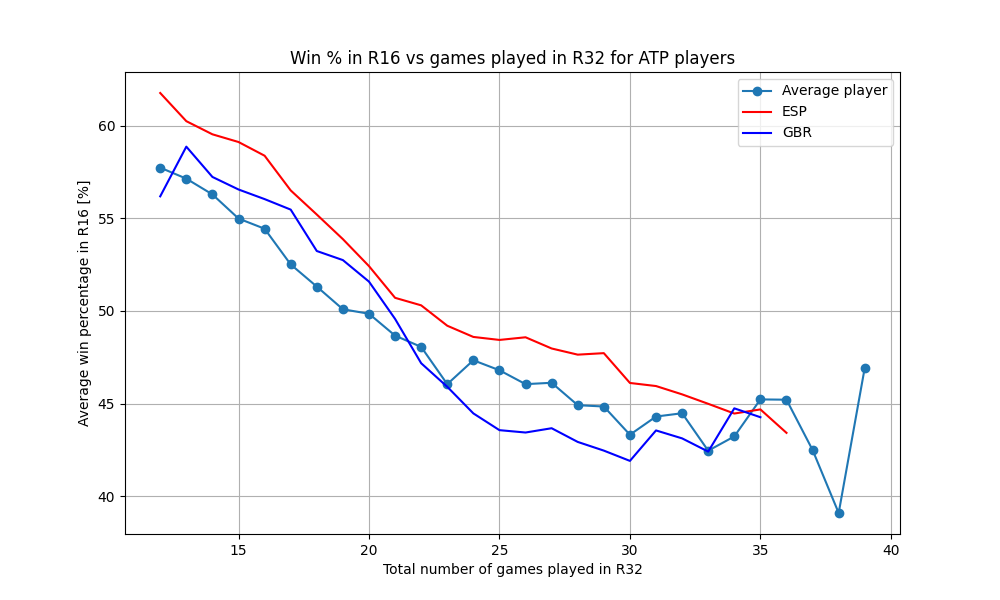

In [127]:
# Plotting using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(games, win_p, marker='o', label='Average player')
ax.plot(games_1, y1, 'r-', label='ESP')
ax.plot(games_2, y2, 'b-', label='GBR')
ax.set_xlabel('Total number of games played in R32')
ax.set_ylabel('Average win percentage in R16 [%]')
ax.set_title('Win % in R16 vs games played in R32 for ATP players')
ax.grid(True)
ax.legend()
plt.show()
%matplot plt

### Player height affecting serve strategy

In [189]:
# Calculate 1st serve in and 1st serve point won ratios
serves = matches.filter((col('tour') == 'ATP')) \
                .select('winner_name', 'winner_ht', 'loser_name', 'loser_ht', \
                        'w_svpt', 'w_1stin', 'w_1stwon', 'l_svpt', 'l_1stin', 'l_1stwon') \
                .withColumn('w_1st_serve_in_ratio', col('w_1stin') / col('w_svpt')) \
                .withColumn('l_1st_serve_in_ratio', col('l_1stin') / col('l_svpt')) \
                .withColumn('w_1st_points_won_ratio', col('w_1stwon') / col('w_1stin')) \
                .withColumn('l_1st_points_won_ratio', col('l_1stwon') / col('l_1stin')) 

# Get the 1st serve in and 1st serve point won ratios grouped by player height
winners_group = serves.groupBy('winner_ht').agg({'w_1st_serve_in_ratio': 'avg', 'w_1st_points_won_ratio': 'avg'})
losers_group = serves.groupBy('loser_ht').agg({'l_1st_serve_in_ratio': 'avg', 'l_1st_points_won_ratio': 'avg'})

df = winners_group.join(losers_group, winners_group['winner_ht'] == losers_group['loser_ht'], 'inner') \
                  .withColumn('1st_serve_in_ratio', (col('avg(w_1st_serve_in_ratio)') + col('avg(l_1st_serve_in_ratio)')) / 2) \
                  .withColumn('1st_points_won_ratio', (col('avg(w_1st_points_won_ratio)') + col('avg(l_1st_points_won_ratio)')) / 2) \
                  .withColumnRenamed('winner_ht', 'height') \
                  .drop('loser_ht', 'avg(w_1st_serve_in_ratio)', 'avg(l_1st_serve_in_ratio)', 'avg(w_1st_points_won_ratio)', 'avg(l_1st_points_won_ratio)') \
                  .dropna().filter(col('height').cast('float').isNotNull()) \
                  .filter(col('height') >= 160).orderBy('height').toPandas()

print(df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   height  1st_serve_in_ratio  1st_points_won_ratio
0     163            0.610675              0.682130
1     165            0.637943              0.641561
2     168            0.602494              0.668481
3     170            0.617911              0.655995
4     172            0.649916              0.650873
5     173            0.619878              0.667476
6     174            0.589598              0.660307
7     175            0.601504              0.679738
8     176            0.612977              0.657512
9     178            0.613601              0.677777
10    180            0.602621              0.688439
11    181            0.560820              0.737977
12    182            0.604978              0.758569
13    183            0.606963              0.694555
14    185            0.600046              0.704826
15    186            0.609212              0.681909
16    188            0.604974              0.712735
17    189            0.679854              0.647718
18    190   

In [190]:
ht = df['height'].astype(float)
first_serve_in_per = df['1st_serve_in_ratio'] * 100
first_points_won_per = df['1st_points_won_ratio'] * 100

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [202]:
# Generate 2nd degree polynomial fit
coeffs1 = np.polyfit(ht, first_serve_in_per, 2)
poly_function1 = np.poly1d(coeffs1)

coeffs2 = np.polyfit(ht, first_points_won_per, 2)
poly_function2 = np.poly1d(coeffs2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

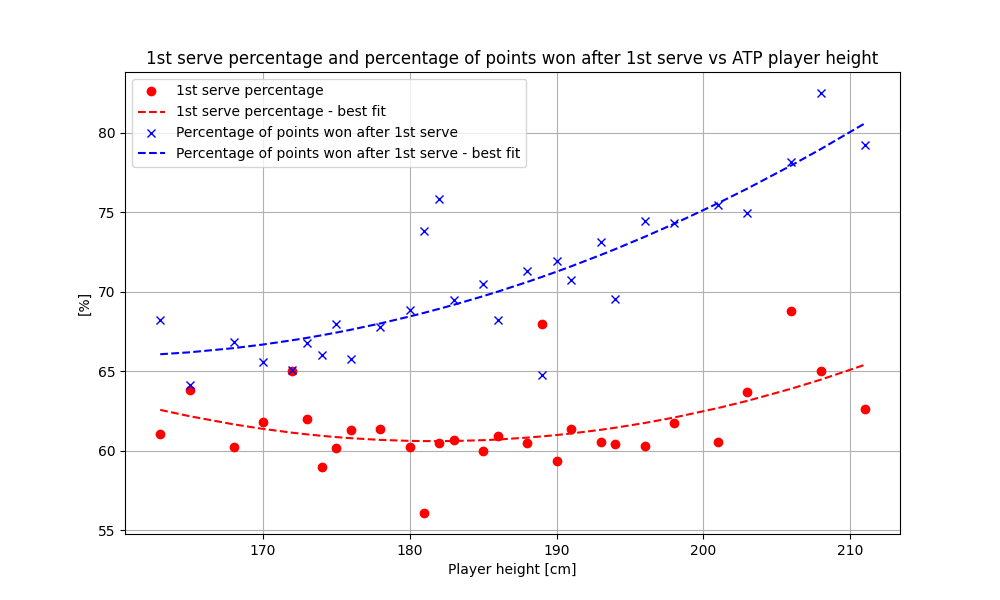

In [203]:
# Plotting using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ht, first_serve_in_per, 'ro', label='1st serve percentage')
ax.plot(ht, poly_function1(ht), 'r--', label='1st serve percentage - best fit')
ax.plot(ht, first_points_won_per, 'bx', label='Percentage of points won after 1st serve')
ax.plot(ht, poly_function2(ht), 'b--', label='Percentage of points won after 1st serve - best fit')
ax.set_xlabel('Player height [cm]')
ax.set_ylabel('[%]')
ax.set_title('1st serve percentage and percentage of points won after 1st serve vs ATP player height')
ax.grid(True)
ax.legend()
plt.show()
%matplot plt